# Mean-Reversion Testing with a Pair Trade Backtesting

In [159]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
from datetime import datetime, timedelta
import statsmodels.tsa.stattools as ts
from statsmodels.regression.rolling import RollingOLS
from arch.unitroot import ADF, ZivotAndrews, KPSS, VarianceRatio, PhillipsPerron 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.simplefilter('ignore')

## Phase 1: Pair selection

#### Download and prepare a time-series and the data frame for pahse 1

In [160]:
symbList = ['EWA', 'EPP'] #select a pair of stocks of etfs
start_date = '2012/06/01'
testdays = 2000 # set days for testing period 
end_date = datetime.now() - timedelta(days = testdays)

# download data from yahoo finance
sym1 = pdr.get_data_yahoo(symbList[0], start = start_date, end = end_date).dropna()
sym2 = pdr.get_data_yahoo(symbList[1], start = start_date, end = end_date).dropna()

# find intersection beetween two series
# make sure DataFrames are the same length 
intersect = sym1.index.intersection(sym2.index)
sym1 = sym1.loc[intersect]
sym2 = sym2.loc[intersect]

# create a dataframe using adj. close prices from both series
pairs = pd.DataFrame(index=sym1.index)
pairs['%s_close' % symbList[0].lower()] = sym1['Adj Close']
pairs['%s_close' % symbList[1].lower()] = sym2['Adj Close']
pairs = pairs.dropna()

#### Calculate hedge ratio and spread

In [161]:
# run regression [y = beta * x], where beta is hedge ratio
# calculate spread as [pair1 + (-beta) * pair2] 
est = sm.OLS(pairs.iloc[:, 0], pairs.iloc[:, 1])
est = est.fit()
pairs['beta'] = -est.params[0]
pairs['spread'] = pairs.iloc[:, 0] + (pairs.iloc[:, 1] * pairs.beta)

#### Test the spread for stationarity and print the results

In [162]:
# Here below we utilise the most popular tests for mean reversion:
	# ADF, PP, ZA: tests for a unit root, i.e. if the spread is non-stationary (not mean reverting) 
	# ADF, PP, ZA: the null hypothesis in the tests is that the spread is not stationary 
	# we want to reject it to assume that the spread as mean reverting (p-value < 0.05).
adf = ADF(pairs.spread)
pp = PhillipsPerron(pairs.spread)
za = ZivotAndrews(pairs.spread)

	# In VARIANCE RATIO the null hypothesis is that a spread is a random walk series
	# we want to reject it to assume that the spread is mean reverting (p-value < 0.05).
vr = VarianceRatio(pairs.spread, 12)
 
	# In KPSS the null hypothesis the tests is that the spread is stationary (mean reverting)
	# we do not want to reject it to assume that the spread as mean reverting (p-value > 0.05).
kpss = KPSS(pairs.spread)

	# HURST evaluates the relative tendency of a time series to revert to the mean
def hurst(ts):
  lags = range(2, 100)
  tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
  poly = np.polyfit(np.log(lags), np.log(tau), 1)
  return poly[0]*2.0
hurst_value = hurst(pairs['spread'].values)

	# HALFLIFE calculates  num of days it takes for the spread to revert to half its initial deviation from the mean
price = pd.Series(pairs.spread)  
lagged_price = price.shift(1).fillna(method="bfill")  
delta = price - lagged_price  
beta = np.polyfit(lagged_price[1:], delta[1:], 1)[0] 
halflife = (-1*np.log(2)/beta)  

### ### ###

# Print all the tests:
print(f'Selected pairs: {symbList[0]} and {symbList[1]}')
print(f'Selection period: {start_date} - {end_date.date()}')
print()
print(f'# TESTS FOR SPREAD MEAN - REVERSION #')
print(f'ADF p-value    = {round(adf.pvalue,2)}') # needs to be less than 0.05
print(f'PP p-value     = {round(pp.pvalue,2)}') # needs to be less than 0.05
print(f'ZA p-value     = {round(za.pvalue,2)}') # needs to be less than 0.05
print(f'VR p-value     = {round(vr.pvalue,2)}') # needs to be less than 0.05
print(f'KPPS p-value   = {round(kpss.pvalue, 3)}') # needs to be more than 0.05
print(f'Hurst exponent = {round(hurst_value,2)}')  # should be less than 0.5
# Halflife is a num of days it takes for the spread to revert to half its 
#initial deviation from the mean:
print(f'Halflife days  = {round(halflife,0)}')  # the lower the better
print()

Selected pairs: EWA and EPP
Selection period: 2012/06/01 - 2014-11-11

# TESTS FOR SPREAD MEAN - REVERSION #
ADF p-value    = 0.07
PP p-value     = 0.06
ZA p-value     = 0.76
VR p-value     = 0.47
KPPS p-value   = 0.123
Hurst exponent = 0.42
Halflife days  = 27.0



Note that for ADF, PP, VR the null is not rejected (assuming 95% CI) which indicates that the series might be a unit root   
However, ZA, KPSS and Hurst exponent tests suggest that the series might not be a unit root.
Please note that for KPSS here the null is not rejected which indicates that the series might not be a unit root.

#### Plot in-sample metrics

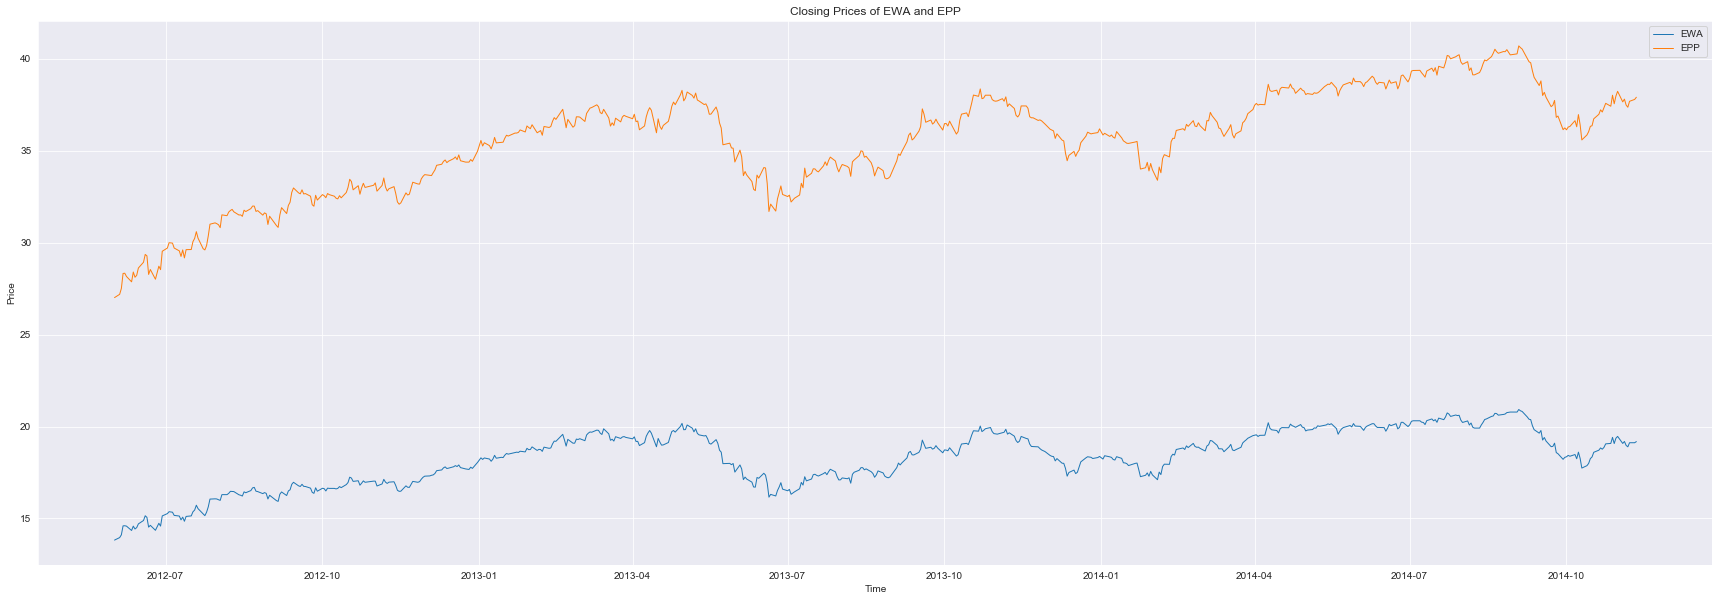

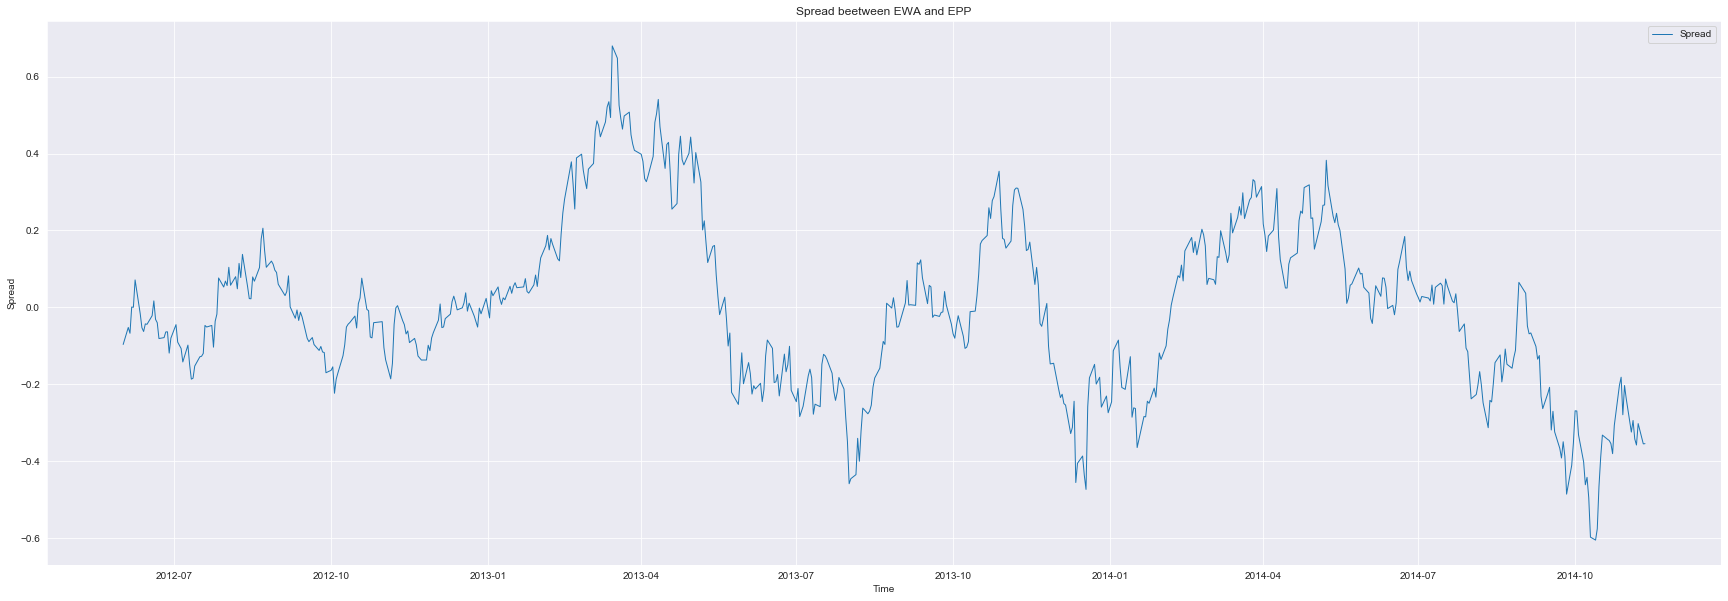

In [163]:
# Plot Closing prices of the selected pair
plt.figure(figsize=(30, 10))
plt.plot(pairs.iloc[:, 0], lw = 1, label = symbList[0]) 
plt.plot(pairs.iloc[:, 1], lw = 1, label = symbList[1])
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc=0)
plt.title(f'Closing Prices of {symbList[0]} and {symbList[1]}')
plt.savefig('prices.png', bbox_inches=None)

# Plot Spread series of the selected pair
plt.figure(figsize=(30, 10))
plt.plot(pairs.spread, lw = 1, label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend(loc=0)
plt.title(f'Spread beetween {symbList[0]} and {symbList[1]}')
plt.savefig('spread.png', bbox_inches=None)

## Phase 2: Pair backtesting

#### Download and prepare time-series and the data frame for pahse 2

In [164]:
# select and download training sample for backtesting
end_date_test = datetime.now()
sym1_test = pdr.get_data_yahoo(symbList[0], start = end_date, end = end_date_test).dropna()
sym2_test = pdr.get_data_yahoo(symbList[1], start = end_date, end = end_date_test).dropna()

# find intersection between two series
# make sure DataFrames are the same length
intersect = sym1_test.index.intersection(sym2_test.index)
series1 = sym1_test.loc[intersect]
series2 = sym2_test.loc[intersect]

# create a dataframe using adj. close prices from both series
df_test = pd.DataFrame(index=series1.index).dropna()
df_test['%s_close' % symbList[0].lower()] = series1['Adj Close']
df_test['%s_close' % symbList[1].lower()] = series2['Adj Close']


#### Calculate rolling hedge ratio and zScore ratio

In [165]:
# selects parameters
roll_beta_window = 10 # or e.g. 'halflife * 2' not sure about this parameter, feel free to experiment :)
zscore_window = min(halflife, 100) #50

# calculates rolling hedge ratio - this allows to dynamically adjust weights
# and to calculate spread in the testing sample 
roll_fit = RollingOLS(df_test.iloc[:, 0], df_test.iloc[:, 1], window=roll_beta_window).fit()
df_test['roll_beta'] = -roll_fit.params 
df_test['test_spread'] = df_test.iloc[:, 0] + (df_test.iloc[:, 1] * df_test.roll_beta)

# calculates Z-score
meanSpread = df_test.test_spread.rolling(window=int(zscore_window)).mean()
stdSpread = df_test.test_spread.rolling(window=int(zscore_window)).std()
df_test['zScore'] = (df_test.test_spread-meanSpread)/stdSpread

#### Create buy/sell signals based on zScore ratio

In [166]:
entryZscore = 2.0
exitZscore = 0.5
df_model = 1 # select a trading model : 1 or 2

	# 1 (standard model): buy/sell when z-score reach an entry threshold, 
	#    and exit when z-score decreses in absolute terms and reaches exit threshold.
	# 2 (alternative model): buy/sell when z-score reach an entry threshold, 
	#    and the current z-score level is higher that the previous one.

if df_model == 1:
  
	# calculate when portfolio is LONG
	# code below (only for model == 1) borrowed from (https://www.pythonforfinance.net/)
	df_test['long_entry'] = ((df_test.zScore < - entryZscore) & ( df_test.zScore.shift(1) > - entryZscore)) 
	df_test['long_exit'] = ((df_test.zScore > - exitZscore) & (df_test.zScore.shift(1) < - exitZscore))  
	df_test.loc[df_test['long_entry'],'pos_long'] = 1 
	df_test.loc[df_test['long_exit'],'pos_long'] = 0 
	df_test['pos_long'][0] = 0 
	df_test['pos_long'] = df_test['pos_long'].fillna(method='pad') 

	#calculate when portfolio is SHORT
	df_test['short_entry'] = ((df_test.zScore > entryZscore) & ( df_test.zScore.shift(1) < entryZscore))
	df_test['short_exit'] = ((df_test.zScore < exitZscore) & (df_test.zScore.shift(1) > exitZscore))
	df_test.loc[df_test['short_entry'],'pos_short'] = -1
	df_test.loc[df_test['short_exit'],'pos_short'] = 0
	df_test['pos_short'][0] = 0
	df_test['pos_short'] = df_test['pos_short'].fillna(method='pad')
if df_model == 2:  	
	#calculate when portfolio is LONG
	df_test['long_entry'] = ((df_test.zScore < -entryZscore) & ( df_test.zScore < df_test.zScore.shift(1))) 
	df_test.loc[df_test['long_entry'],'pos_long'] = 1 
	df_test['pos_long'] = df_test['pos_long'].fillna(0) 
	#calculate when portfolio is SHORT
	df_test['short_entry'] = ((df_test.zScore > entryZscore) & ( df_test.zScore > df_test.zScore.shift(1)))
	df_test.loc[df_test['short_entry'],'pos_short'] = -1
	df_test['pos_short'] = df_test['pos_short'].fillna(0)

# combine longs/shorts and remove Look ahead bias by lagging the signal
df_test['position'] = df_test['pos_long'].shift(1) + df_test['pos_short'].shift(1)
pd.set_option('display.max_rows', 3000)


#### Calculate backtest metrics

In [167]:
df_test['long_entry'] = ((df_test.pos_long.shift(1) == 1) & ((df_test.position - df_test.position.shift(1)) == 1)) * 1
df_test['long_exit'] = ((df_test.long_exit == True) & (df_test.position == 1)) * 1
df_test['short_entry'] = ((df_test.pos_short.shift(1) == -1)  & ((df_test.position - df_test.position.shift(1)) == -1)) * 1
df_test['short_exit'] = ((df_test.short_exit == True) & (df_test.position == -1)) * 1

# calculates pct returns assuming you are always long
df_test['pct_ret'] = ((df_test['test_spread'] - df_test['test_spread'].shift(1)) / 
                    (df_test.iloc[:, 0].shift(1) + (abs(df_test['roll_beta']) * df_test.iloc[:, 1].shift(1))))

# your actual portfolio return for that day according to your position
df_test['port_ret'] = df_test['position'] * df_test['pct_ret'] 
df_test['port_ret'].fillna(0.0, inplace=True)

# trading fees (set here as 0.1%: - slippage + transaction fees, for example you pay 1 USD per 1,000 value of trade
tr_costs = 0.001
df_test['tr_cost_paid'] = (df_test.long_entry | df_test.long_exit | df_test.short_entry | df_test.short_exit)
df_test['port_ret_net'] = df_test['port_ret'] - ( tr_costs * df_test['tr_cost_paid'])

# culmulative porfolio return gross and net
df_test['cum_port_ret'] = (df_test['port_ret'] + 1.0).cumprod()
df_test['cum_port_ret_net'] = (df_test['port_ret_net'] + 1.0).cumprod()

# HELPER FIGURES
# calculate average and std_dev of your actual returns (skip zeros)
mean = df_test.query("position == 1 or position  == -1")['port_ret'].mean()
std = df_test.query("position == 1 or position  == -1")['port_ret'].std()
mean_net = df_test.query("position == 1 or position  == -1")['port_ret_net'].mean()
std_net = df_test.query("position == 1 or position  == -1")['port_ret_net'].std()
# calculates how many days your portfolio hold any positions (is fully invested)
num_days_in_the_market = len(df_test.query("position == 1 or position  == -1")['port_ret'])
# calculate sum of long and short entries
num_trades_long = df_test.query('long_entry == True')['long_entry'].sum()
num_trades_short = df_test.query('short_entry == True')['short_entry'].sum()
# calculate total trading costs paid
approx_tr_costs = (num_trades_long + num_trades_short) * tr_costs

'''Since the strategy isn't always fully invested, we skip 'zero retun days' in calculating Sharpe Ratio and CAGR.
To adjust this SR ratio, you have to decide what you're going to do with that capital when you're not invested'''

# PERFORMANCE STATS (gross - no trading costs included)
# calculates Sharpe Ratio, Total Return and CAGR
sharp_ratio = (mean / std) * np.sqrt(252)
cum_return = df_test['cum_port_ret'].iloc[-1] - 1.0
comp_ann_return = ((df_test['cum_port_ret'].iloc[-1] / df_test['cum_port_ret'].iloc[0]) ** (1 / (num_days_in_the_market / 365) ) ) - 1.0

# PERFORMANCE STATS (net - trading costs included)
sharp_ratio_net = (mean_net / std_net) * np.sqrt(252)
cum_return_net = df_test['cum_port_ret_net'].iloc[-1] - 1.0
comp_ann_return_net = ((df_test['cum_port_ret_net'].iloc[-1] / df_test['cum_port_ret_net'].iloc[0]) ** (1 / (num_days_in_the_market / 365) ) ) - 1.0


### ### ###

# Print perfromance statistics
print(f'Bactesting period: {end_date.date()} - {end_date_test.date()}')
print()
print(f'# BACKTEST PERFORMANCE GROSS #')
print(f'+ Sharpe Ratio           : {round(sharp_ratio, 2)}')
print(f'+ Cumulative Return      : {round(cum_return,3)}')
print(f'+ Cum Annual Growth Rate : {round(comp_ann_return, 3)}')
print(f'+ Average Return         : {round(mean, 4)}')
print(f'+ Standard Deviation     : {round(std,4)}')
print()
print(f'# BACKTEST PERFORMANCE NET #')
print(f'+ Sharpe Ratio           : {round(sharp_ratio_net, 2)}')
print(f'+ Cumulative Return      : {round(cum_return_net,3)}')
print(f'+ Cum Annual Growth Rate : {round(comp_ann_return_net, 3)}')
print(f'+ Average Return         : {round(mean_net, 4)}')
print(f'+ Standard Deviation     : {round(std_net,4)}')
print()
print(f'# OTHER BACKTEST METRICS #')
print(f'+ Num Long Entries       : {num_trades_long}')
print(f'+ Num Short Entries      : {num_trades_short}')
print(f'+ Days in the market     : {num_days_in_the_market}')
print(f'+ Total fees paid        : {round(approx_tr_costs, 4)}')

#df_test
#df_test.to_csv('test_sample.csv')

Bactesting period: 2014-11-11 - 2020-05-03

# BACKTEST PERFORMANCE GROSS #
+ Sharpe Ratio           : 4.62
+ Cumulative Return      : 0.202
+ Cum Annual Growth Rate : 0.303
+ Average Return         : 0.0007
+ Standard Deviation     : 0.0025

# BACKTEST PERFORMANCE NET #
+ Sharpe Ratio           : 2.62
+ Cumulative Return      : 0.105
+ Cum Annual Growth Rate : 0.155
+ Average Return         : 0.0004
+ Standard Deviation     : 0.0024

# OTHER BACKTEST METRICS #
+ Num Long Entries       : 22
+ Num Short Entries      : 21
+ Days in the market     : 253
+ Total fees paid        : 0.043


#### Plot out-of-sample metrics 

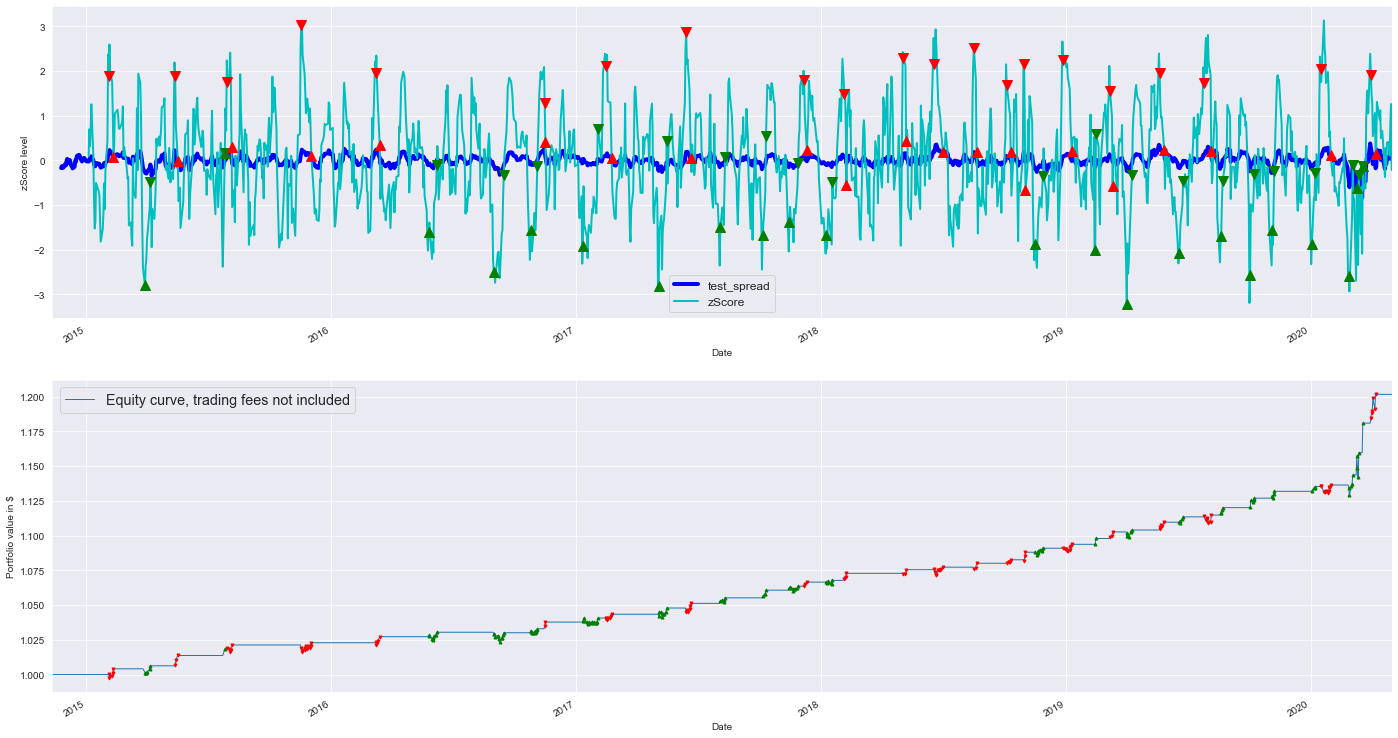

In [168]:
fig = plt.figure(figsize=(24, 14))
fig.patch.set_facecolor('white')     # Set the outer colour to white
ax1 = fig.add_subplot(211,  ylabel='zScore level')
    
# Plot the pair spread overlaid with zScores
df_test[['test_spread']].plot(ax=ax1, color='b', lw=4.)
df_test[['zScore']].plot(ax=ax1, color='c', lw=2.)
ax1.legend(loc=0, fontsize='large')

# Plot the "long entry" trades against Z-score
ax1.plot(df_test.ix[df_test.long_entry == 1.0].index, 
             df_test.zScore[df_test.long_entry == 1.0],
             '^', markersize=10, color='g')

# Plot the "short entry" trades against Z-score
ax1.plot(df_test.ix[df_test.short_entry == 1.0].index, 
             df_test.zScore[df_test.short_entry == 1.0],
             'v', markersize=10, color='r')

# Plot the "buy exit" trades against Z-score
ax1.plot(df_test.ix[df_test.long_exit == 1.0].index, 
             df_test.zScore[df_test.long_exit == 1.0],
             'v', markersize=10, color='g')

# Plot the "sell exit" trades against Z-score
ax1.plot(df_test.ix[df_test.short_exit == 1.0].index, 
             df_test.zScore[df_test.short_exit == 1.0],
             '^', markersize=10, color='r')

# Plot the equity curve starting with 1 unit (1 USD)
ax2 = fig.add_subplot(212, ylabel='Portfolio value in $', xlabel ='Time')
df_test['cum_port_ret'].plot(ax=ax2, lw=1, label = 'Equity curve, trading fees not included')
ax2.legend(loc=0, fontsize='x-large')
#ax2.title(f'EQUITY CURVE, $1 investment, trading fees not included')


# Plot the "long positions" and "short positions" trades against the equity curve
ax2.plot(df_test.ix[df_test.position == 1.0].index, 
             df_test.cum_port_ret[df_test.position == 1.0],
             '^', markersize=3, color='g')
ax2.plot(df_test.ix[df_test.position == -1.0].index, 
             df_test.cum_port_ret[df_test.position == -1.0],
             'v', markersize=3, color='r')

# Plot the figures
fig.show()